## COMP5329 Assignment 2


Members:
1. Zhuoyang Li (480164337)
2. Melissa Tan (200249191)
3. Jimmy Yue   (440159151)

## Instruction to run

1. Change the path to the location where the train & test files resides (in the **Library** and **Extract gz files** section )
2. Click on run all to execute the entire code 


This Notebook is designed to run on GPU. If running Colab, click on the **Runtime** on the menu bar and click on **change runtime type**. Then change hardware accelerator to GPU

# Library


In [0]:
import math, os, sys
import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import itertools
from scipy import misc, ndimage
from sklearn.metrics import confusion_matrix
from IPython.display import SVG

import numpy as np
import itertools
import h5py
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

SEED = 42
histories = {}
# for reproducebility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED) # set seed for numoy generated randon mumbers
random.seed(SEED)    # set seed for python random numbers

# file path
FOLDER_ID = '1PPBJhVV5pmBOEzRAS7AgUR1q-rtKxG5W'
LOCAL_PATH = '/content/gdrive/My Drive/tmp/'  # local path to store model as gpu env gets wiped out
LOG_DIR = './log'
TRAIN_PATH = '/home/jupyter/.keras/datasets/train2014'
TEST_PATH = '/home/jupyter/.keras/datasets/test'
LABEL_PATH = '/home/jupyter/.keras/datasets/train.txt'

# training default parameters
BATCH_SIZE = 16
SPLIT = 0.4  # test/validation split
EPOCH = 25
WORKER = 4
LR = 0.00001  # learning rate
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3) # height, width, 3 RGB channel


TensorFlow version is  1.13.1


# Setup

In [0]:
# for drawing network diagram
!pip install pydot graphviz
!pip install pydot3 pydot-ng

  Using cached https://files.pythonhosted.org/packages/33/d1/b1479a770f66d962f545c2101630ce1d5592d90cb4f083d38862e93d16d2/pydot-1.4.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1f/e2/ef2581b5b86625657afd32030f90cf2717456c1d2b711ba074bf007c0f1a/graphviz-0.10.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/dd/d9/3ec19e966301a6e25769976999bd7bbe552016f0d32b577dc9d63d2e0c49/pyparsing-2.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3c/5b/9a08333f2d70d404ffe42cea4f50159c4ad94feaa4d7585551c05cacef46/pydot_ng-2.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/dd/d9/3ec19e966301a6e25769976999bd7bbe552016f0d32b577dc9d63d2e0c49/pyparsing-2.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/51/f45cea425fd5cb0b0380f5b0f048ebc1da5b417e48d304838c02d6288a1e/setuptools-41.0.1-py2.py3-none-any.whl


## Setup Tensor Board on colab

In [0]:
# https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

#  fire up the TensorBoard in the background like this:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    
    
# Clear any logs from previous runs
!rm -rf ./log/ 

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.5/json/__init__.py", line 268, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.5/json/__init__.py", line 319, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.5/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.5/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


## Check GPU

In [0]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Thu May 30 09:55:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Functions

## Plot Acc v Loss

In [0]:
# Function to view accuracy & loss chart
def plotResult(model, model_name):
    trainAcc = model.history['acc']
    valAcc = model.history['val_acc']

    trainLoss = model.history['loss']
    valLoss = model.history['val_loss']

    epochs = range(len(trainAcc))
    plt.figure(figsize=(12,6))
    plt.plot(epochs, trainAcc, 'b', label='training acc')
    plt.plot(epochs, valAcc, 'r', label='validation acc')

    bestEpoch = np.argmin(model.history["val_loss"])
    bestAcc = trainAcc[bestEpoch]
    bestValAcc = valAcc[bestEpoch]
    minTrainLoss = trainLoss[bestEpoch]
    minValLoss = valLoss[bestEpoch]

    print(model_name)
    print('bestEpoch | bestAcc | bestValAcc : ', bestEpoch , ' | ' , bestAcc , ' | ' , bestValAcc)
    print('minTrainLoss | minValLoss : ', minTrainLoss, ' | ' , minValLoss)
    
    plt.plot(bestEpoch, bestValAcc, marker="x", color="r", label="best model")
    #plt.title('Training and validation accuracy ' + model_name)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    
    plt.legend()

    plt.figure(figsize=(12,6))

    plt.plot(epochs, trainLoss, 'steelblue', label='Training loss')
    plt.plot(epochs, valLoss, 'tomato', label='Validation loss')
    plt.plot( np.argmin(model.history["val_loss"]), np.min(model.history["val_loss"]), 
             marker="x", color="tomato", label="best model")

    #plt.title('Training and validation loss ' + model_name)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    
    plt.legend()

    plt.show()


## Metrics
Supposed {2,10} is the ground truth . 

Then {2}, {10}, {2, 10}, {10, 2} are all right answers, if you give one of them, you will get the full score. Others are wrong answers.

### Custom function

In [0]:
import keras.backend as K

def acc_threshold(y_true, y_pred_prob, threshold=0.5):
      # requires specify threshold
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.convert_to_tensor(y_pred_prob > threshold)

    # use bitwise operator. 1&1=1, 0&1=0, 1&0=0, 0&0=0. Therefore the result will return 1 if both actual & pred are 1
    correct = tf.math.logical_and(y_true, y_pred, name='correct') 
    incorrect = tf.subtract( tf.cast(correct, tf.int8), tf.cast(y_pred, tf.int8), name='incorrect')
    reduced = tf.reduce_sum(incorrect, axis=1) 
    total_wrong = tf.shape(tf.boolean_mask(incorrect, reduced))[0]
    total_record = tf.shape(y_true)[0]
    total_correct = total_record - total_wrong
    acc = tf.math.divide( total_correct , total_record  ) 
    return acc

Using TensorFlow backend.


### Verification

In [0]:
import keras.backend as K
actual =  np.array([
    [1, 0, 1, 0],
    [1, 1, 1, 1],
    [0, 1, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])

pred_prob =  np.array([
    [0.9, 0.4, 0.9, 0.1],  # CORRECT: 100% match
    [0.3, 0.4, 0.5, 0.8],  # CORRECT: predicted is a subset of actual. Even if not all label were predicted correctly
    [0.1, 0.5, 0.5, 0.4],  # CORRECT: predicted is a subset of actual. Even if not all label were predicted correctly
    [0.3, 0.7, 0.8, 0.2],  # WRONG  : column index 2 is not a subset of actual. Even if columnn index 2 is predicted correctly
    [0.6, 0.7, 0.7, 0.2]   # WRONG  : 100% mismatch
])


init_op = tf.global_variables_initializer()
with tf.Session() as sess: 
    sess.run(init_op) 
    print(sess.run(acc_threshold(actual, pred_prob, 0.5)) )
  

0.6


In [0]:
#! ls -al ./log
#! rm -r ./log
#! rm ./*.h5

! rm -rf /home/jupyter/.local/share/Trash

## Callback

In [0]:
def callbacks(filename):
    return [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor = 'val_loss', verbose=1),
    #tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filename, verbose=1, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR + '/'+ filename)
    ]
  

# File IO

The below extract the zip files from GCP bucket. Note bucket may **NO** longer be available after 31 May 2019 as it is a paid storage.# File IO

## Extract gz from GCP

Extract from Google Cloud Platform bucket

In [0]:
def extractFile():


    import pathlib
    data_root = tf.keras.utils.get_file(fname='train',
                                        origin='https://storage.googleapis.com/dlcomp5329/train.tar.gz', 
                                        untar=True)
    data_root = pathlib.Path(data_root)

    data_root = tf.keras.utils.get_file(fname='test',
                                        origin='https://storage.googleapis.com/dlcomp5329/test.tar.gz', 
                                        untar=True)
    data_root = pathlib.Path(data_root)
    
    data_root = tf.keras.utils.get_file(fname='train.txt',
                                    origin='https://storage.googleapis.com/dlcomp5329/train.txt', 
                                    untar=False)
    data_root = pathlib.Path(data_root)

    print(data_root)
    
    ! mkdir -p /home/jupyter/.keras/datasets/test/
    ! mv /home/jupyter/.keras/datasets/val2014 /home/jupyter/.keras/datasets/test/val2014


## Extract gz files from google drive

In [0]:
def extractFile(folderId):
    !pip install -U -q PyDrive 

    # read from google drive
    import os
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    local_download_path = os.path.expanduser('~/data')

    try:
      os.makedirs(local_download_path)
    except: pass

    file_list = drive.ListFile(
        {'q': "'" + folderId + "' in parents"}).GetList()
    
    # list files
    for f in file_list:
      print('title: %s, id: %s' % (f['title'], f['id']))
      fname = os.path.join(local_download_path, f['title'])
      print('downloading to {}'.format(fname))
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)

    # create directories. 
    # -p: make parent directories if not exist
    !mkdir -p /content/train/
    !mkdir -p /content/test/
    
    # untar file into /content/
    # x: This option tells tar to extract the files.
    # v: The “v” stands for “verbose.” This option will list all of the files one by one in the archive.
    # z: The z option is very important and tells the tar command to uncompress the file (gzip).
    # f: This options tells tar that you are going to give it a file name to work with.
    !tar xvzf /root/data/train.tar.gz -C /content/train/
    !tar xvzf /root/data/test.tar.gz  -C /content/test/
    
    # move train.txt file to train directory
    !mv /root/data/train.txt /content/train/train.txt



## Create Data Generator



1.   simple -  rescaled image without transformations
2.   augmented - rescaled image tranformed through shifting, zooming, rotation, flipping and etc to prevent overfitting and helps the model generalize better.

In [0]:
# Original images consist in RGB (0-255) but the values would be too high for our models to process (given a typical learning rate), so we scale with a 1/255 factor
# Create a second data generator to augment data. Data augmentation is one way to fight overfitting, but it isn't enough since augmented samples are still highly correlated.

def createDataGen(split=0.2):
    dataGens = {}

  # simple gen
    tmp = tf.keras.preprocessing.image.ImageDataGenerator(
      validation_split=split,
      rescale=1./255)
  
    dataGens['simple'] = tmp
  
  # augmented
    tmp = tf.keras.preprocessing.image.ImageDataGenerator(
      validation_split=split,
      rotation_range=40,       # rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
      rescale=1./255,          
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
      height_shift_range=0.1,  # randomly shift images vertically (fraction of total height))
      fill_mode='nearest')     # strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift
  
    dataGens['augmented'] = tmp

    return dataGens


## Data Pipeline -Train & Test


In [0]:
def loadData(datagen, path, df, classes, batchSize, seed):
    t = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path,
        subset='training',     # training 
        x_col='filename',      # column of dataframe that contain image filename
        y_col=classes,
        batch_size=batchSize,
        seed=seed,
        shuffle=False,
        class_mode="other",
        target_size=IMAGE_SIZE)

    v = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path,
        subset='validation',   # validation
        x_col='filename',      # column of dataframe that contain image filename
        y_col=classes,
        batch_size=batchSize,
        seed=seed,
        shuffle=False,
        class_mode="other",
        target_size=IMAGE_SIZE)

    return (t,v)


def loadTestData(path, batchSize, seed):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
  
    return datagen.flow_from_directory(
        directory=path,
        batch_size=batchSize,
        seed=seed,
        shuffle=False,
        class_mode=None,  # generator will only yield batches of data without labels
        target_size=IMAGE_SIZE)




## Data Pipeline -  Label

In [0]:
import pandas as pd

def loadTrainLabel(path):
    with open(path, 'rb') as f:
        lines = [x.decode('utf8').strip('').strip('\n') for x in f.readlines()]
        trainY = np.zeros((len(lines), 20))

    for row, line in enumerate(lines):
        labels = line.split('\t')[1].split(',')

        # read training labels and do one hot encode
        for col in labels:
            trainY[row, int(col)] = 1


    df = pd.DataFrame(trainY)
    df['filename'] = df.index.values.astype(str)
    df['filename'] = df.apply(lambda x: x.filename +'.jpg', axis=1)
    return df

# Load Data

In [0]:
# one off extract process to unzip files and place in correct directory
extractFile('11bT7FFLq-zD517gtLfTYVtZceiOE-772');
#extractFile();

# load train label 
trainY_df = loadTrainLabel(LABEL_PATH)
classes = trainY_df.columns[:-1]
print(trainY_df.shape)
print(trainY_df.head())

# create various data genenrator. ie basic & augmented
dataGens = createDataGen(split=SPLIT)


TRAIN_COUNT = len(os.listdir(TRAIN_PATH))
TRAIN_STEP_SIZE = math.floor(TRAIN_COUNT/BATCH_SIZE) * (1-SPLIT)
VALID_STEP_SIZE = math.floor(TRAIN_COUNT/BATCH_SIZE) * SPLIT


409600/407622 [==============================] - 0s 0us/step
/home/jupyter/.keras/datasets/train.txt
mv: cannot stat '/home/jupyter/.keras/datasets/val2014': No such file or directory
(31925, 21)
     0    1    2    3    4    5    6    7    8    9  ...   11   12   13   14  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   

    15   16   17   18   19  filename  
0  0.0  0.0  0.0  1.0  0.0     0.jpg  
1  0.0  0.0  0.0  0.0  1.0     1.jpg  
2  0.0  0.0  0.0  0.0  0.0     2.jpg  
3  0.0  0.0  0.0  0.0  0.0     3.jpg  
4  0.0  0.0  0.0  0.0  0.0     4.jpg  

[5 rows x 21 columns]


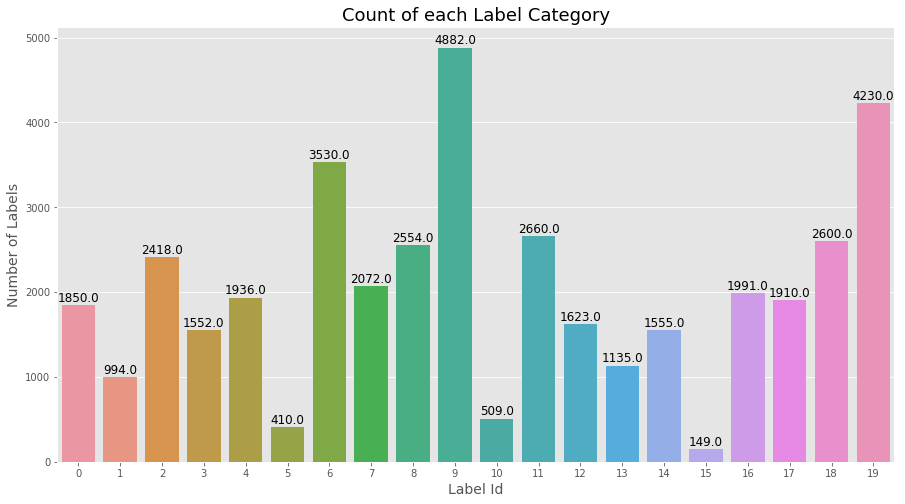

In [0]:

data_raw = trainY_df.iloc[:,0:-1]
categories = list(data_raw.columns.values)

plt.figure(figsize=(15,8))
ax = sns.barplot(categories, data_raw.sum().values)
plt.title("Count of each Label Category", fontsize=18)
plt.ylabel('Number of Labels', fontsize=14)
plt.xlabel('Label Id', fontsize=14)

#adding the text labels
rects = ax.patches
labels = data_raw.sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
plt.show()

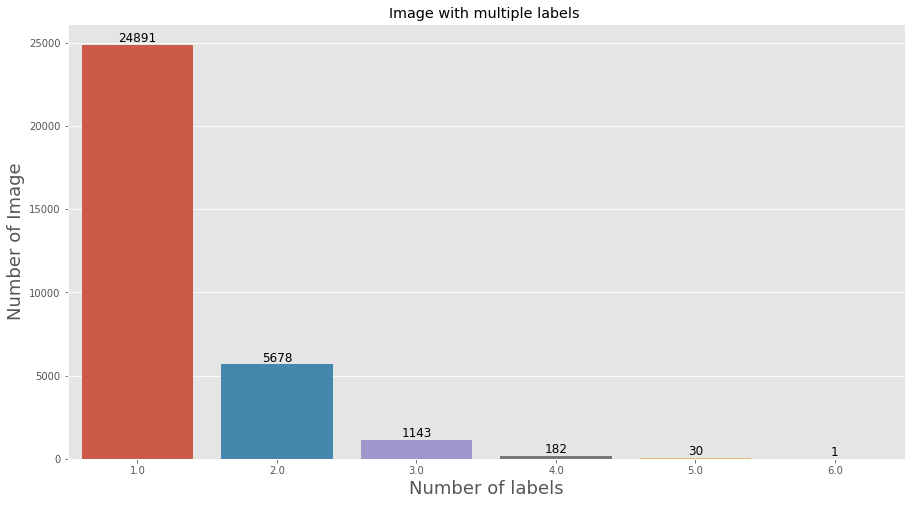

In [0]:
rowSums = data_raw.sum(axis=1)
multiLabel_counts = rowSums.value_counts()

plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Image with multiple labels ")
plt.ylabel('Number of Image', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
plt.show()

# Base Model

In [0]:
def model(model, model_name, train, val, classes, lr):

    model.layers.pop()
    for layer in model.layers:
        layer.trainable=False
    last = model.layers[-1].output
    x = tf.keras.layers.Dense(len(classes), activation="sigmoid")(last)
    finetuned_model = tf.keras.Model(model.input, x)
    finetuned_model.compile(tf.keras.optimizers.Adam(lr=LR, decay=1e-6), 
                            loss="binary_crossentropy", metrics=["accuracy", custom_accuracy ])
                            #loss="categorical_crossentropy", metrics=["accuracy", custom_accuracy ])

    # update the weights
    model_fitted = finetuned_model.fit_generator(
          generator = train,
          steps_per_epoch = train.n//train.batch_size,
          validation_data = val,
          validation_steps = val.n//val.batch_size,
          epochs = EPOCH,
          workers=WORKER,
          callbacks = callbacks(model_name + '.h5'))
  
    return model_fitted
  

# Features Extraction

Use pretrain models as a feature extractor and customize a classifier. The convolution section of the pretrain models are froozen by setting the *layer.trainable = False* . This will prevent the weights in these layers from being updated during training.



In [0]:
# store all models
models = {}

# setup resnet as base model 
models['vgg16'] = tf.keras.applications.vgg16.VGG16(input_shape=INPUT_SHAPE, include_top=False,weights='imagenet')
models['resNet'] = tf.keras.applications.resnet50.ResNet50(include_top=False,weights='imagenet')
models['mobileNet'] = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False,weights='imagenet')
EPOCH = 15

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 19155 images.
Found 12770 images.


mobileNet
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________
trainable variables 2
Instructions for updating:
Use tf.cast instead.
799/799 [==============================] - 166s 208ms/step - loss: 0.1696 - acc: 0.9419
mobileNet
bestEpoch | bestAcc | bestValAcc :  14  |  0.9406187  |  0.9418607
minTrainLoss | minValLoss :  0.17156665584914088  |  0.16958089700628431


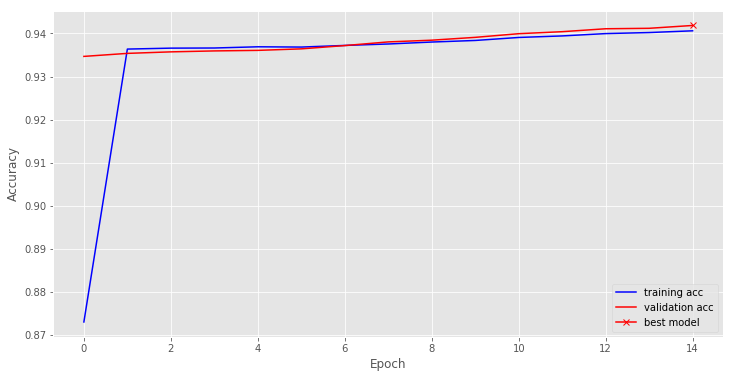

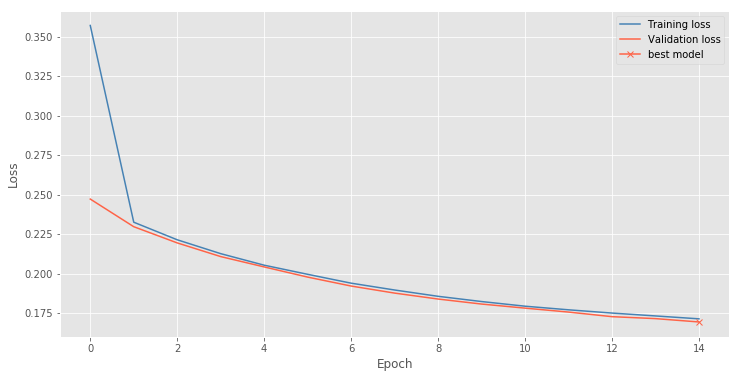



vgg16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                10260     
Total params: 14,724,948
Trainable params: 10,260
Non-trainable params: 14,714,688
_________________________________________________________________
trainable variables 2
799/799 [==============================] - 162s 202ms/step - loss: 0.2138 - acc: 0.9360
vgg16
bestEpoch | bestAcc | bestValAcc :  14  |  0.9367736  |  0.93602926
minTrainLoss | minValLoss :  0.2124986432545243  |  0.21381642940793377


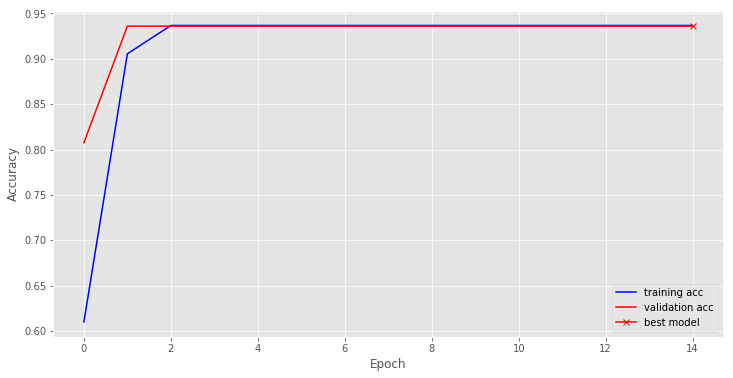

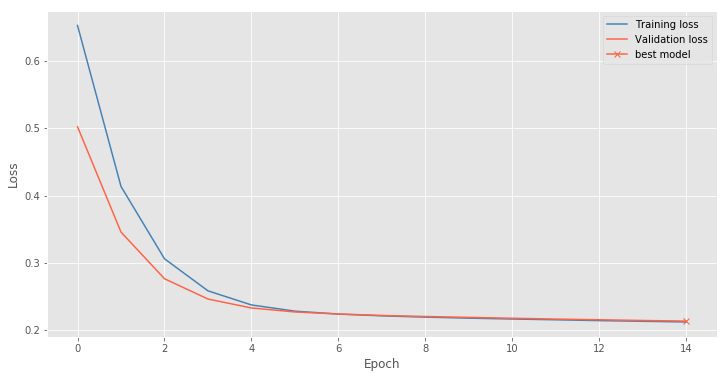



resNet
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________
trainable variables 2
799/799 [==============================] - 166s 208ms/step - loss: 0.1603 - acc: 0.9429
resNet
bestEpoch | bestAcc | bestValAcc :  14  |  0.94275653  |  0.94285023
minTrainLoss | minValLoss :  0.16042153599429648  |  0.1603064007208553


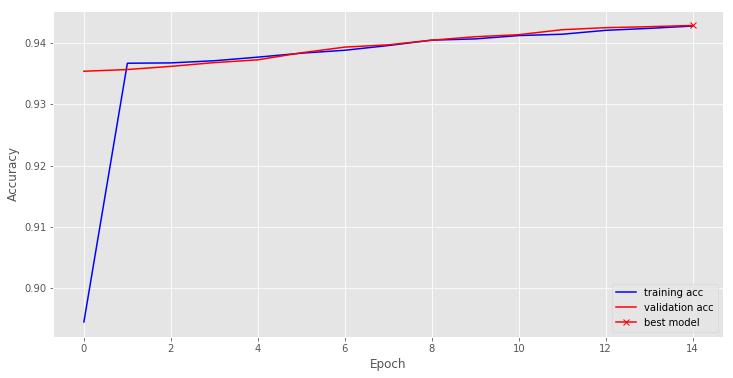

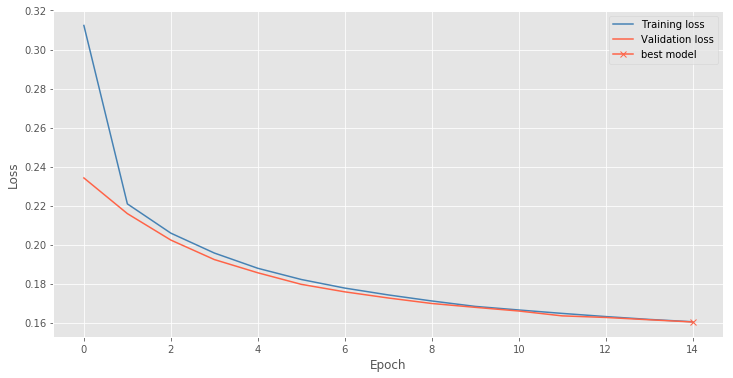

In [0]:
# since augmented data gives better result

trainGen, valGen = loadData(datagen=dataGens['augmented'], path=TRAIN_PATH, df=trainY_df, 
                         classes=classes, batchSize=BATCH_SIZE, seed=SEED)

for model_key, base_model in models.items():
    print("\n\n==============")
    print(model_key)
    print("==============")
    
    # freeze the convolutional parts
    base_model.trainable = False

    # add customized classification
    model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(classes), activation='sigmoid')
    ])

    # compile model
    model.compile(tf.keras.optimizers.Adam(lr=LR, decay=1e-6), 
                loss="binary_crossentropy", metrics=["accuracy"])

    model.summary()
    print('trainable variables', len(model.trainable_variables))

    # run training
    cb = callbacks(model_key +'.hd5')
    history = model.fit_generator(
        generator = trainGen,
        steps_per_epoch = trainGen.n//trainGen.batch_size,
        validation_data = valGen,
        validation_steps = valGen.n//valGen.batch_size,
        epochs = EPOCH,
        verbose=0,
        #callbacks = cb
        )
    histories[model_key] = history
    
    # Save the weights
    model.save_weights(model_key + '_weights.h5')
    model.save(model_key + '.h5')
    plotResult(history, model_key)

# Finetuning

In feature extraction, the weights of the pre-trained network were frozen thus they are not updated during training. In this section we will "fine-tune" the weights of the top layers (last few layers before flattening) of the pre-trained model whilst training the top-level classifier. The structure of a CNN is such that the the first few layers contains high level generic features but as the layers goes deeper, they are incresingly more specific to the dataset that was orginally trained on.The training process will further tune the weights to specifically based on the features of the new dataset.

 

mobileNet
Count of layers in the base model:  155
108
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________
trainable variables 2
Epoch 1/15
799/799 [==============================] - 169s 211ms/step - loss: 0.1591 - acc: 0.9435

Epoch 00001: val_loss improved from inf to 0.15906, saving model to fine_tuned_mobileNet.hd5

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to man

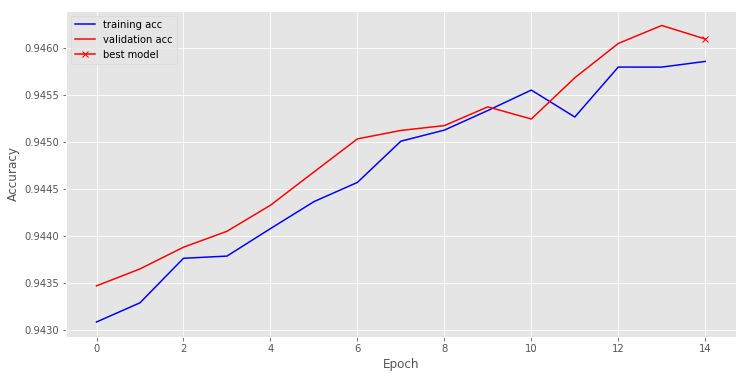

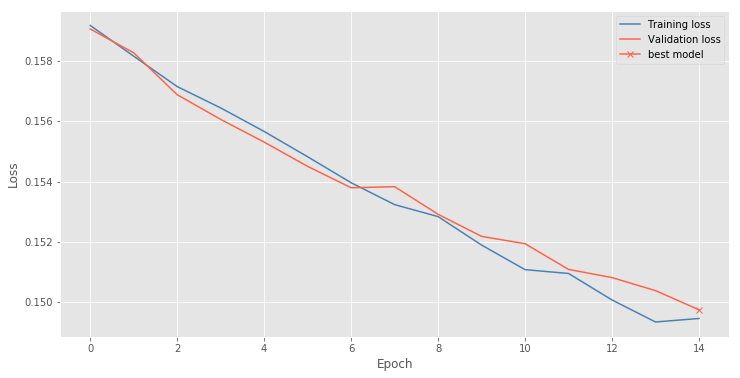

vgg16
Count of layers in the base model:  19
13
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________
trainable variables 2
Epoch 1/15
799/799 [==============================] - 169s 211ms/step - loss: 0.1492 - acc: 0.9465

Epoch 00001: val_loss improved from inf to 0.14921, saving model to fine_tuned_vgg16.hd5

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] - 430s 359ms/step - loss: 0.148

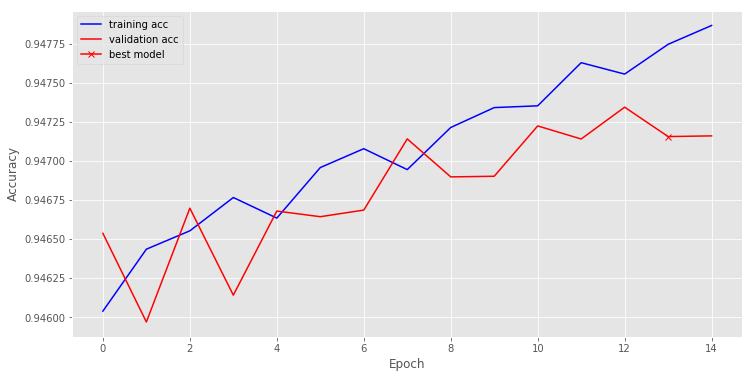

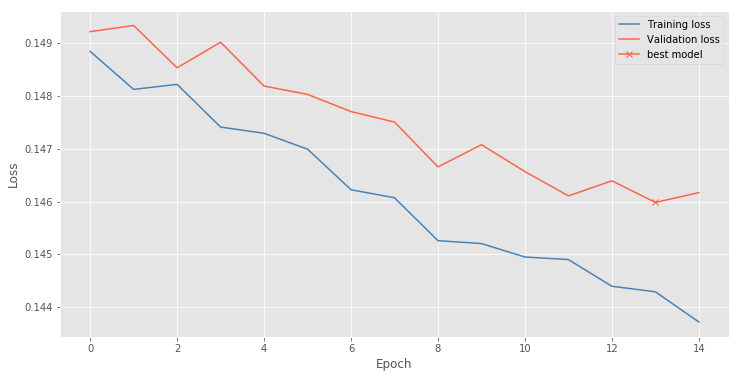

resNet
Count of layers in the base model:  175
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 17,254,420
Non-trainable params: 6,374,272
_________________________________________________________________
trainable variables 66
Epoch 1/15
799/799 [==============================] - 166s 208ms/step - loss: 0.1332 - acc: 0.9516

Epoch 00001: val_loss improved from inf to 0.13319, saving model to fine_tuned_resNet.hd5

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] - 427s 357ms/step - los

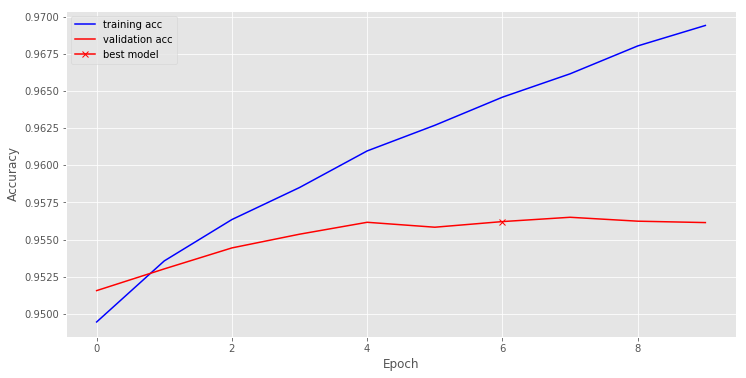

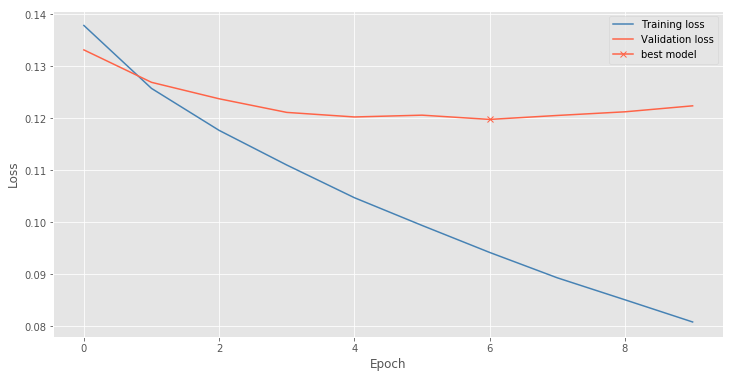

In [0]:
from keras.utils.vis_utils import model_to_dot

for model_key, base_model in models.items():
    print(model_key)

    # Unfreeze base model
    base_model.trainable = True

    # Check number of layers
    print("Count of layers in the base model: ", len(base_model.layers))

    # Fine tune the last 10% layer
    cut_off = int(len(base_model.layers) * 0.7)
    print(cut_off)

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:cut_off]:
        layer.trainable =  False

    # compile model
    model.compile(tf.keras.optimizers.Adam(lr=LR), 
                loss="binary_crossentropy", metrics=["accuracy"])

    model.summary()
    #SVG(model_to_dot(model).create(prog='dot', format='svg'))

    print('trainable variables', len(model.trainable_variables))

    # run training
    cb = callbacks('fine_tuned_' + model_key +'.hd5')
    history = model.fit_generator(
          generator = trainGen,
          steps_per_epoch = trainGen.n//trainGen.batch_size,
          validation_data = valGen,
          validation_steps = valGen.n//valGen.batch_size,
          epochs = EPOCH
          ,callbacks = cb
    )
    histories['fine_tuned_' + model_key ] = history
    model.save_weights('fine_tuned_' + model_key +'_weight.h5')
    model.save('fine_tuned_' + model_key + '.h5')
    plotResult(history, 'fine_tuned_' + model_key )

In [0]:
import csv
# backup history as csv
w = csv.writer(open("histories_final.csv", "w"))
for key, val in histories.items():
    w.writerow(key)
    print(key)

    
    w.writerow([key+'_loss', val.history['loss']])
    w.writerow([key+'_val_loss', val.history['val_loss']])
    w.writerow([key+'_acc', val.history['acc']])
    w.writerow([key+'_val_acc', val.history['val_acc']])


fine_tuned_mobileNet
vgg16
fine_tuned_vgg16
mobileNet
fine_tuned_resNet
resNet


# Results

fine_tuned_mobileNet
bestEpoch | bestAcc | bestValAcc :  14  |  0.94585484  |  0.94609296
minTrainLoss | minValLoss :  0.14946501227652426  |  0.14975302023008857


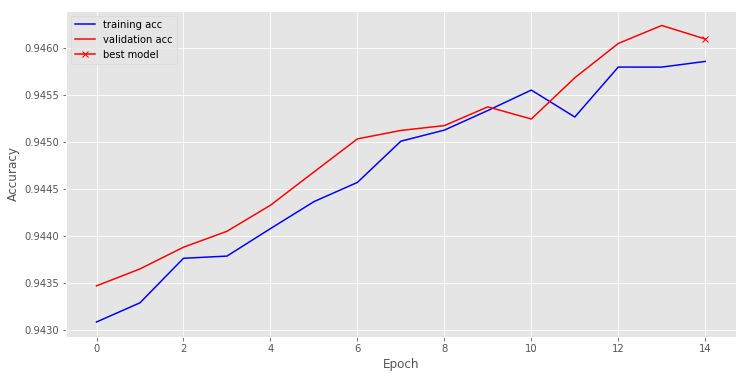

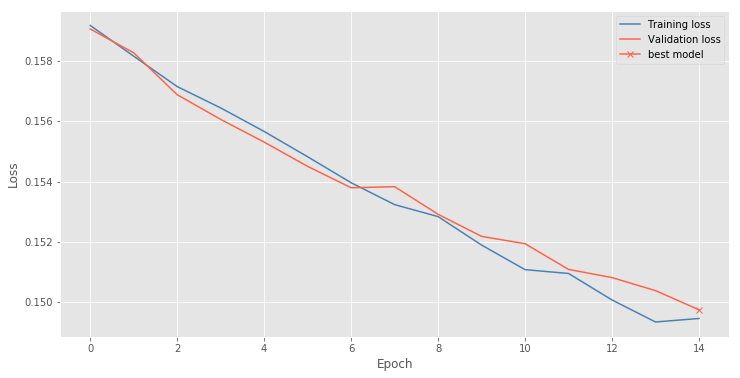

vgg16
bestEpoch | bestAcc | bestValAcc :  14  |  0.9367736  |  0.93602926
minTrainLoss | minValLoss :  0.2124986432545243  |  0.21381642940793377


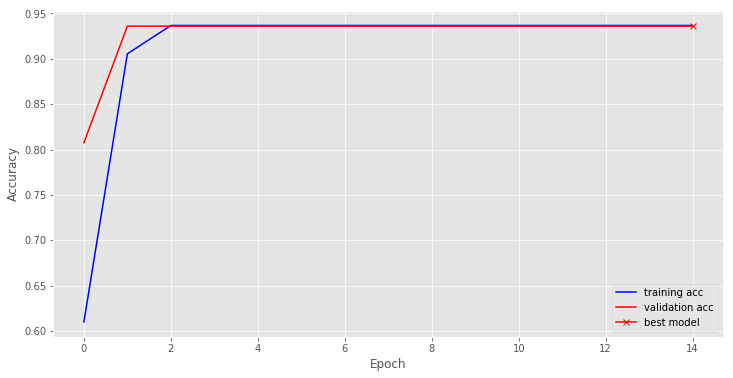

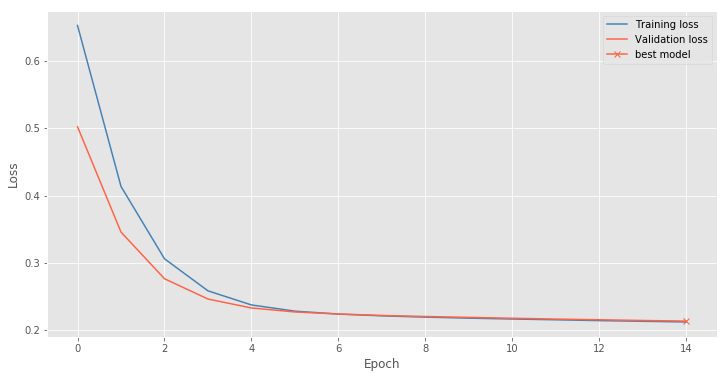

fine_tuned_vgg16
bestEpoch | bestAcc | bestValAcc :  13  |  0.9477473  |  0.947157
minTrainLoss | minValLoss :  0.14429309504970625  |  0.14598303330183326


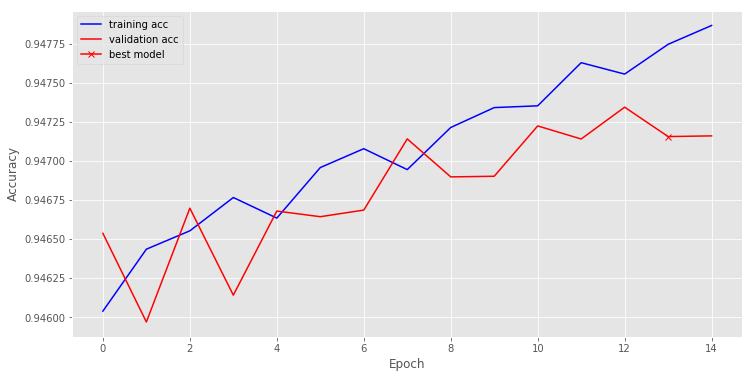

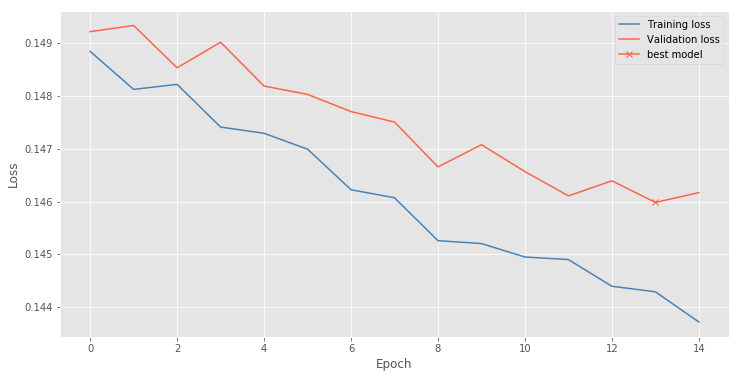

mobileNet
bestEpoch | bestAcc | bestValAcc :  14  |  0.9406187  |  0.9418607
minTrainLoss | minValLoss :  0.17156665584914088  |  0.16958089700628431


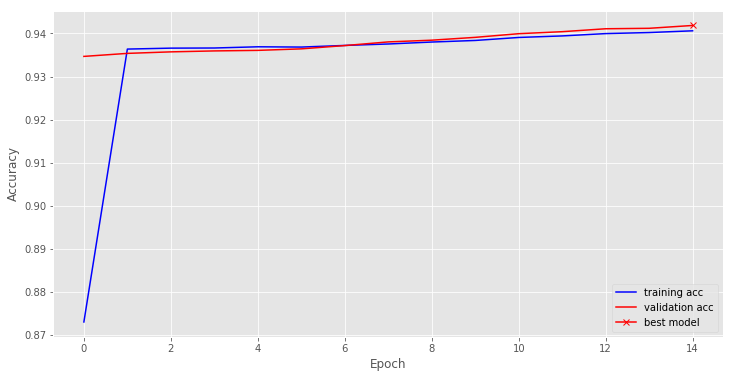

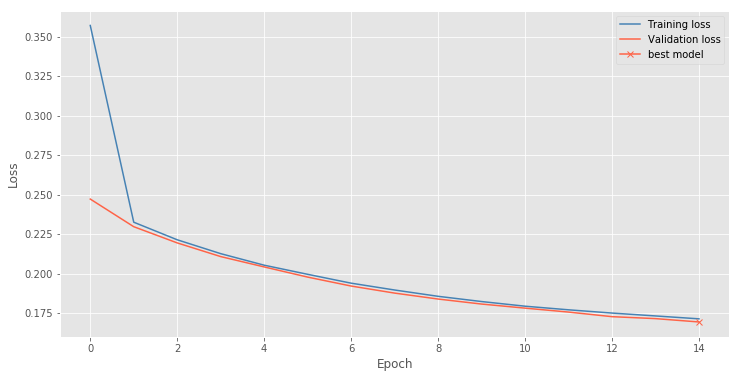

fine_tuned_resNet
bestEpoch | bestAcc | bestValAcc :  6  |  0.9645971  |  0.9562136
minTrainLoss | minValLoss :  0.09422970539135399  |  0.11981697072821654


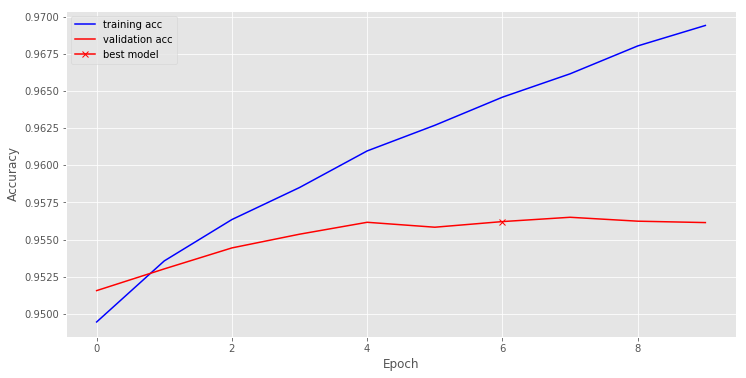

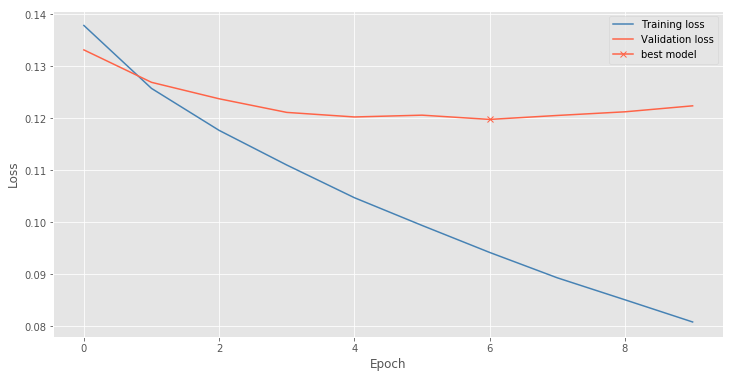

resNet
bestEpoch | bestAcc | bestValAcc :  14  |  0.94275653  |  0.94285023
minTrainLoss | minValLoss :  0.16042153599429648  |  0.1603064007208553


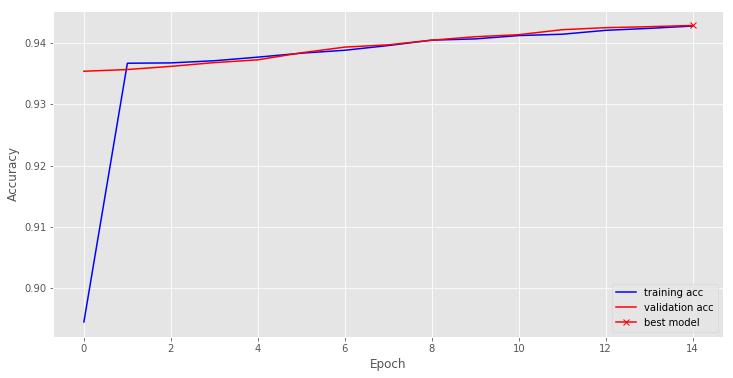

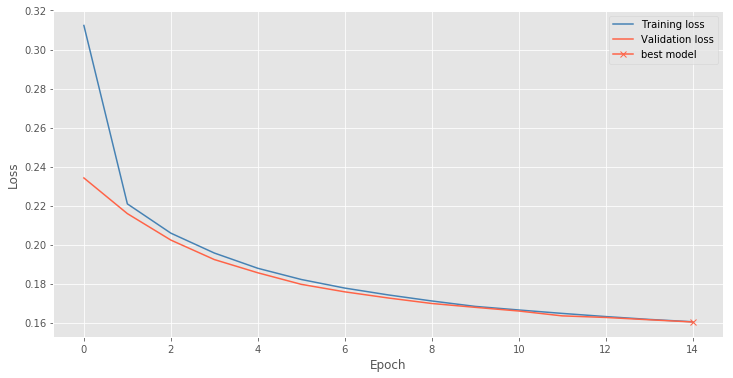

In [0]:
for k,v in histories.items():
    plotResult(v, k)

# Load DL model

In [0]:
# Load model
from keras.models import load_model
model = load_model('fine_tuned_resnet.h5)
model.compile(tf.keras.optimizers.Adam(lr=LR, decay=1e-6), 
            loss="binary_crossentropy", metrics=["accuracy"])
                           

# Predict

In [0]:
finalModel = model

In [0]:
finalModel.summary()
                           

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 17,254,420
Non-trainable params: 6,374,272
_________________________________________________________________


In [0]:
testGen = loadTestData(path=TEST_PATH, batchSize=BATCH_SIZE, seed=SEED)
pred = finalModel.predict_generator(testGen, steps=testGen.n//testGen.batch_size, verbose=1)

Found 15516 images belonging to 1 classes.
970/970 [==============================] - 85s 87ms/step


In [0]:
result = pd.DataFrame(pred)
result['file'] = testGen.filenames
result.index = result['file'].apply(lambda x:x.replace('val2014/',''))
del result['file'] 
result.to_csv('result.csv')
result.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
file,,,,,,,,,,,,,,,,,,,,
0.jpg,0.006540,0.027858,0.487188,0.002003,0.000718,0.002057,0.448414,0.000744,8.315444e-04,0.062385,0.000298,0.017542,0.000614,0.000154,0.001031,0.000174,0.000602,0.002670,0.018068,0.059314
1.jpg,0.001885,0.000008,0.000244,0.000134,0.000077,0.000040,0.076200,0.704066,9.580635e-01,0.555968,0.000040,0.013418,0.039125,0.006961,0.010123,0.001394,0.013583,0.000633,0.016597,0.038191
10.jpg,0.000371,0.000004,0.031947,0.000005,0.658486,0.003762,0.055981,0.000005,6.258488e-07,0.000182,0.000002,0.285309,0.000045,0.000007,0.000004,0.000002,0.000006,0.001201,0.000062,0.000753
100.jpg,0.000196,0.019887,0.197249,0.016400,0.000555,0.000289,0.017649,0.001476,3.971577e-03,0.086633,0.005774,0.168503,0.000204,0.000720,0.005517,0.003672,0.016315,0.002767,0.010895,0.267420
1000.jpg,0.000238,0.000036,0.000329,0.000337,0.000499,0.001865,0.000688,0.000865,4.020035e-04,0.003532,0.000282,0.999991,0.000681,0.000871,0.000321,0.000204,0.001829,0.012345,0.002223,0.000542


In [0]:
#import pandas as pd
#import numpy as np
#result = pd.read_csv('result.csv')
#result = result.set_index('file')
#del result.index.name
#result.head(10)

In [0]:
# function to pick out the columns that exceed threshold
def label(df):
    l = np.where(df>0.5)[0] 
    df['label'] =  ','.join(str(e) for e in l)
    return df

result = result.apply(label, axis=1)

#set at least one label
result.label = np.where(result.label.eq(''), np.argmax(result.iloc[:,0:20].values, axis=1), result.label)
result.head(20)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
file,,,,,,,,,,,,,,,,,,,,,
0.jpg,0.006540,0.027858,4.871883e-01,0.002003,0.000718,0.002057,0.448414,0.000744,8.315444e-04,0.062385,...,0.017542,0.000614,0.000154,0.001031,0.000174,6.024837e-04,0.002670,0.018068,0.059314,2
1.jpg,0.001885,0.000008,2.438724e-04,0.000134,0.000077,0.000040,0.076200,0.704066,9.580635e-01,0.555968,...,0.013418,0.039125,0.006961,0.010123,0.001394,1.358271e-02,0.000633,0.016597,0.038191,"7,8,9"
10.jpg,0.000371,0.000004,3.194669e-02,0.000005,0.658486,0.003762,0.055981,0.000005,6.258488e-07,0.000182,...,0.285309,0.000045,0.000007,0.000004,0.000002,6.049871e-06,0.001201,0.000062,0.000753,4
100.jpg,0.000196,0.019887,1.972489e-01,0.016400,0.000555,0.000289,0.017649,0.001476,3.971577e-03,0.086633,...,0.168503,0.000204,0.000720,0.005517,0.003672,1.631451e-02,0.002767,0.010895,0.267420,19
1000.jpg,0.000238,0.000036,3.287792e-04,0.000337,0.000499,0.001865,0.000688,0.000865,4.020035e-04,0.003532,...,0.999991,0.000681,0.000871,0.000321,0.000204,1.829207e-03,0.012345,0.002223,0.000542,11
10000.jpg,0.000005,0.000025,9.238720e-07,0.001362,0.000004,0.000002,0.000327,0.000620,9.956083e-01,0.000575,...,0.000282,0.000021,0.283748,0.113768,0.000016,6.425083e-04,0.000027,0.000033,0.000112,8
10001.jpg,0.001436,0.000857,7.966757e-04,0.000051,0.000518,0.000091,0.019245,0.000312,8.093715e-04,0.618826,...,0.041726,0.000364,0.000007,0.000915,0.001247,8.291018e-02,0.000139,0.315844,0.435085,9
10002.jpg,0.999843,0.000006,7.468462e-05,0.000658,0.000754,0.000271,0.027089,0.000098,1.554191e-04,0.003206,...,0.001347,0.000075,0.000018,0.001571,0.000035,2.920628e-05,0.002653,0.001739,0.010700,0
10003.jpg,0.000024,0.000007,5.897880e-05,0.000008,0.000045,0.000251,0.001223,0.006101,3.720360e-01,0.804652,...,0.001457,0.007737,0.000474,0.008386,0.000176,1.165444e-01,0.001085,0.000565,0.024650,9


In [0]:
# save file 
result.label.to_csv('testY.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


/home/jupyter/.keras/datasets/test/val2014/0.jpg
2


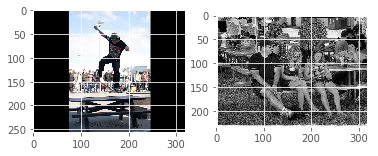

/home/jupyter/.keras/datasets/test/val2014/1.jpg
7,8,9


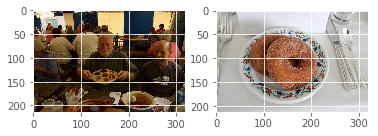

/home/jupyter/.keras/datasets/test/val2014/2.jpg
6


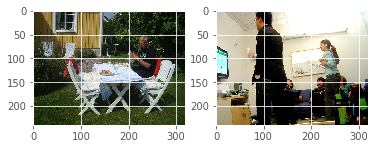

/home/jupyter/.keras/datasets/test/val2014/3.jpg
14


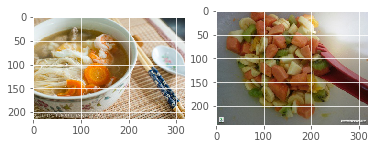

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import time

%matplotlib inline


TEST_SAMPLE_PATH = "/home/jupyter/.keras/datasets/test/val2014/{0}.jpg"
TRAIN_SAMPLE_PATH = "/home/jupyter/.keras/datasets/train2014/{0}.jpg"

#EQUIVALENT TRAIN LABEL {2, (7,8,9), 6, 14 }
trainSample = [3,4,25,157] 

for i in range(0,4):
        
    plt.subplot(1, 2, 1)
    p = TEST_SAMPLE_PATH.format(i)
    print (p)
    print(result.label.loc[str(i) +'.jpg'])
    image = mpimg.imread(p) # images are color images
    #plt.gca().clear()
    plt.imshow(image);
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
    #time.sleep(2.0) # wait one second
   
    plt.subplot(1, 2, 2)
    p = TRAIN_SAMPLE_PATH.format(trainSample[i])
    
    image = mpimg.imread(p) # images are color images
    #plt.gca().clear()
    plt.imshow(image);
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
    #time.sleep(2.0) # wait one second
    
    plt.show()
    